In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/hw4_realse_dataset.zip' #change into your data path
extract_path = '/content/data/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
import os
import re
from torch.utils.data import Dataset
from PIL import Image


class RainSnowDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.degraded_dir = os.path.join(root_dir, 'train', 'degraded')
        self.clean_dir = os.path.join(root_dir, 'train', 'clean')

        # Keep only valid PNG images
        self.filenames = sorted([
            f for f in os.listdir(self.degraded_dir)
            if f.lower().endswith('.png') and not f.startswith('.')
        ])
        self.transform = transform

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        degraded_filename = self.filenames[idx]
        degraded_path = os.path.join(self.degraded_dir, degraded_filename)

        # Parse prefix (rain/snow) and index from the filename
        match = re.match(r'^(rain|snow)-(\d+)\.png$', degraded_filename)
        if not match:
            raise ValueError(f"Invalid filename format: {degraded_filename}")

        prefix, number = match.groups()
        clean_filename = f"{prefix}_clean-{number}.png"
        clean_path = os.path.join(self.clean_dir, clean_filename)

        # Open images
        degraded = Image.open(degraded_path).convert("RGB")
        clean = Image.open(clean_path).convert("RGB")

        if self.transform:
            degraded = self.transform(degraded)
            clean = self.transform(clean)

        return degraded, clean


In [5]:
import os
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Load the full dataset
dataset = RainSnowDataset('/content/data/hw4_realse_dataset', transform=transform)

# Compute train/validation split sizes (80% for training, 20% for validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Randomly split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation datasets
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [7]:
print(f"Total training data: {len(train_dataset)}")
print(f"Total validation data: {len(val_dataset)}")

Total training data: 2560
Total validation data: 640


Degraded batch shape: torch.Size([4, 3, 256, 256])
Clean batch shape: torch.Size([4, 3, 256, 256])
float32 0.0 1.0
float32 0.0 1.0
float32 0.0 1.0
float32 0.0 1.0


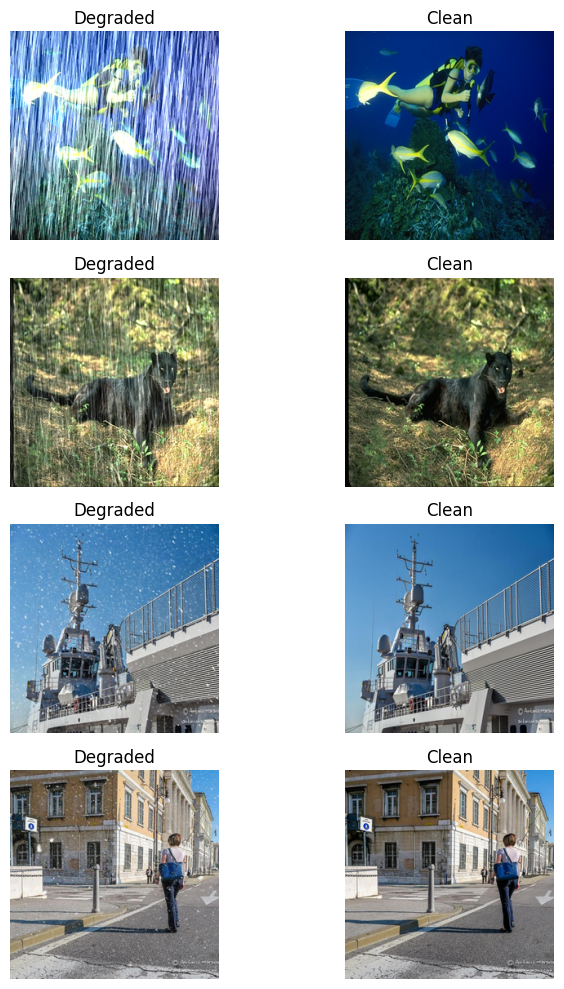

In [6]:
import matplotlib.pyplot as plt
import torchvision

# Retrieve one batch
for degraded_batch, clean_batch in train_dataloader:
    print(f"Degraded batch shape: {degraded_batch.shape}")
    print(f"Clean batch shape: {clean_batch.shape}")

    # Display the first 4 image pairs (8 is too crowded)
    num_show = 4
    fig, axes = plt.subplots(num_show, 2, figsize=(8, num_show * 2.5))

    for i in range(num_show):
        # Convert from [C, H, W] to [H, W, C]
        degraded_img = degraded_batch[i].permute(1, 2, 0).numpy()
        clean_img = clean_batch[i].permute(1, 2, 0).numpy()

        print(degraded_img.dtype, degraded_img.min(), degraded_img.max())

        axes[i, 0].imshow(degraded_img)
        axes[i, 0].set_title("Degraded")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(clean_img)
        axes[i, 1].set_title("Clean")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    break  # Only visualize the first batch

In [8]:
degraded, clean = dataset[0]
print(f"Degraded shape: {degraded.shape}")
print(f"Clean shape: {clean.shape}")

Degraded shape: torch.Size([3, 256, 256])
Clean shape: torch.Size([3, 256, 256])


# PromptIR official

In [9]:
!mkdir -p net
!wget https://raw.githubusercontent.com/va1shn9v/PromptIR/main/net/model.py -O net/model.py

--2025-05-26 07:13:45--  https://raw.githubusercontent.com/va1shn9v/PromptIR/main/net/model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15000 (15K) [text/plain]
Saving to: ‘net/model.py’

net/model.py        100%[===================>]  14.65K  --.-KB/s    in 0s      

2025-05-26 07:13:46 (126 MB/s) - ‘net/model.py’ saved [15000/15000]



In [10]:
import torch
import torch.nn as nn
from net.model import (
    OverlapPatchEmbed,
    Downsample,
    Upsample,
    TransformerBlock,
    PromptGenBlock,
)


class PromptIR_like(nn.Module):
    def __init__(
        self,
        in_c=3,
        embed_dim=48,
        num_blocks=2,
        num_heads=4,
        ffn_expansion_factor=2.66,
        bias=False,
        LayerNorm_type='BiasFree'
    ):
        super(PromptIR_like, self).__init__()

        self.patch_embed = OverlapPatchEmbed(
            in_c=in_c, embed_dim=embed_dim, bias=bias
        )



        # Downsample
        self.down1 = Downsample(embed_dim)
        self.down2 = Downsample(embed_dim * 2)

        # Encoder blocks
        self.encoder1 = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, ffn_expansion_factor,
                             bias, LayerNorm_type)
            for _ in range(num_blocks)
        ])
        self.encoder2 = nn.Sequential(*[
            TransformerBlock(embed_dim * 2, num_heads, ffn_expansion_factor,
                             bias, LayerNorm_type)
            for _ in range(num_blocks)
        ])
        self.encoder3 = nn.Sequential(*[
            TransformerBlock(embed_dim * 4, num_heads, ffn_expansion_factor,
                             bias, LayerNorm_type)
            for _ in range(num_blocks)
        ])

        # Decoder blocks
        self.decoder3 = nn.Sequential(*[
            TransformerBlock(embed_dim * 4, num_heads, ffn_expansion_factor,
                             bias, LayerNorm_type)
            for _ in range(num_blocks)
        ])
        self.up2 = Upsample(embed_dim * 4)        # -> 2C
        self.decoder2 = nn.Sequential(*[
            TransformerBlock(embed_dim * 2, num_heads, ffn_expansion_factor,
                             bias, LayerNorm_type)
            for _ in range(num_blocks)
        ])
        self.up1 = Upsample(embed_dim * 2)        # -> C
        self.decoder1 = nn.Sequential(*[
            TransformerBlock(embed_dim, num_heads, ffn_expansion_factor,
                             bias, LayerNorm_type)
            for _ in range(num_blocks)
        ])

        self.prompt3 = PromptGenBlock(
            prompt_dim=embed_dim * 4, prompt_len=5, prompt_size=24,
            lin_dim=embed_dim * 4
        )
        self.prompt_reduce3 = nn.Conv2d(embed_dim * 4, 32, 1)
        self.noise_level3 = nn.Sequential(
            nn.Conv2d(embed_dim * 4 + 32, embed_dim * 4, 1),
            nn.GELU()
        )

        # Output layer
        self.out_layer = nn.Sequential(
            nn.Conv2d(embed_dim, in_c, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Step 1: embedding
        x_embed = self.patch_embed(x)             # B, C, H, W

        # Step 2: Encoder with downsampling
        e1 = self.encoder1(x_embed)
        down_1 = self.down1(e1)
        e2 = self.encoder2(down_1)
        down_2 = self.down2(e2)

        e3 = self.encoder3(down_2)

        # Step 3: Decoder with upsampling and skip connections
        p3 = self.prompt3(e3)
        p3 = self.prompt_reduce3(p3)
        d3 = torch.cat([e3, p3], dim=1)
        d3 = self.noise_level3(d3)
        d3 = self.decoder3(d3)

        u2 = self.up2(d3) + e2

        d2 = self.decoder2(u2)

        u1 = self.up1(d2) + e1
        d1 = self.decoder1(u1)

        # Step 4: Output
        out = self.out_layer(d1 + x_embed)
        return out


# Start training

In [11]:
import torch
import torch.nn as nn

class CharbonnierLoss(nn.Module):
    def __init__(self, epsilon=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.epsilon = epsilon

    def forward(self, x, y):
        diff = x - y
        loss = torch.sqrt(diff * diff + self.epsilon * self.epsilon)
        return loss.mean()

In [12]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PromptIR_like().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = CharbonnierLoss()

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Early Stopping
best_val_loss = float('inf')
patience = 3
patience_counter = 0
save_path = 'best_model.pth'

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for degraded, clean in tqdm(train_dataloader):
        degraded, clean = degraded.to(device), clean.to(device)

        outputs = model(degraded)
        loss = criterion(outputs, clean)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(
        f'\nEpoch [{epoch + 1}/{num_epochs}], '
        f'Training Loss: {running_loss / len(train_dataloader):.6f}'
    )

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for degraded, clean in val_dataloader:
            degraded, clean = degraded.to(device), clean.to(device)
            outputs = model(degraded)
            loss = criterion(outputs, clean)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    print(f'Validation Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        print(
            f'Validation loss improved: '
            f'{best_val_loss:.6f} -> {avg_val_loss:.6f}. Saving model.'
        )
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        patience_counter = 0
    else:
        patience_counter += 1
        print(f'No improvement. Early stopping counter: {patience_counter}/{patience}')
        if patience_counter >= patience:
            print('Early stopping triggered.')
            break

print(f'Best model saved to {save_path} with validation loss: {best_val_loss:.6f}')


100%|██████████| 640/640 [09:43<00:00,  1.10it/s]



Epoch [1/10], Training Loss: 0.073933
Validation Loss: 0.052186
Validation loss improved: inf -> 0.052186. Saving model.


100%|██████████| 640/640 [09:41<00:00,  1.10it/s]



Epoch [2/10], Training Loss: 0.054558
Validation Loss: 0.056661
No improvement. Early stopping counter: 1/3


100%|██████████| 640/640 [09:38<00:00,  1.11it/s]



Epoch [3/10], Training Loss: 0.048305
Validation Loss: 0.055679
No improvement. Early stopping counter: 2/3


100%|██████████| 640/640 [09:37<00:00,  1.11it/s]



Epoch [4/10], Training Loss: 0.045685
Validation Loss: 0.041594
Validation loss improved: 0.052186 -> 0.041594. Saving model.


100%|██████████| 640/640 [09:36<00:00,  1.11it/s]



Epoch [5/10], Training Loss: 0.043223
Validation Loss: 0.044147
No improvement. Early stopping counter: 1/3


100%|██████████| 640/640 [09:33<00:00,  1.12it/s]



Epoch [6/10], Training Loss: 0.041567
Validation Loss: 0.041313
Validation loss improved: 0.041594 -> 0.041313. Saving model.


100%|██████████| 640/640 [09:34<00:00,  1.11it/s]



Epoch [7/10], Training Loss: 0.040040
Validation Loss: 0.045632
No improvement. Early stopping counter: 1/3


100%|██████████| 640/640 [09:33<00:00,  1.12it/s]



Epoch [8/10], Training Loss: 0.040238
Validation Loss: 0.037210
Validation loss improved: 0.041313 -> 0.037210. Saving model.


100%|██████████| 640/640 [09:33<00:00,  1.12it/s]



Epoch [9/10], Training Loss: 0.038537
Validation Loss: 0.036730
Validation loss improved: 0.037210 -> 0.036730. Saving model.


100%|██████████| 640/640 [09:31<00:00,  1.12it/s]



Epoch [10/10], Training Loss: 0.037738
Validation Loss: 0.036685
Validation loss improved: 0.036730 -> 0.036685. Saving model.
Best model saved to best_model.pth with validation loss: 0.036685


In [13]:
model.load_state_dict(torch.load('best_model.pth', map_location=device))

<All keys matched successfully>

In [14]:
import torch
import torch.nn.functional as F


def calculate_psnr(output, target, max_pixel_value=1.0):
    mse = F.mse_loss(output, target)
    if mse == 0:
        return float('inf')
    psnr = 20 * torch.log10(max_pixel_value / torch.sqrt(mse))
    return psnr.item()

In [15]:
model.eval()
psnr_total = 0

with torch.no_grad():
    for degraded, clean in val_dataloader:
        degraded = degraded.to(device)
        clean = clean.to(device)
        output = model(degraded)
        psnr = calculate_psnr(output, clean)
        psnr_total += psnr

average_psnr = psnr_total / len(val_dataloader)
print(f"Validation PSNR: {average_psnr:.2f} dB")

Validation PSNR: 25.32 dB


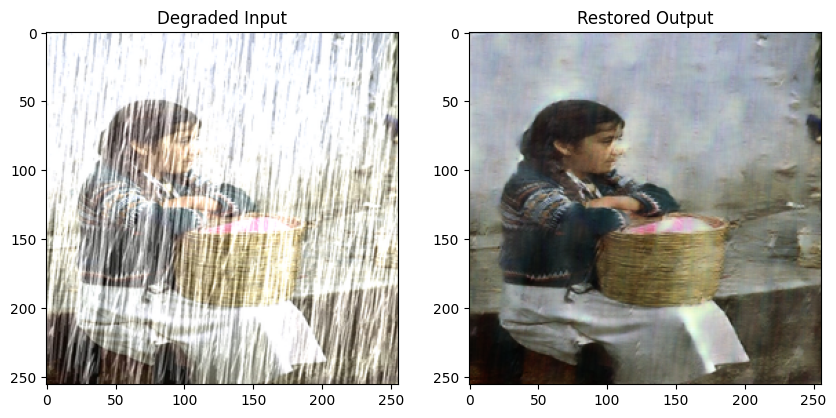

In [16]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# 1. Load test image
test_image_path = '/content/data/hw4_realse_dataset/test/degraded/1.png'  # Replace with your file path
image = Image.open(test_image_path).convert("RGB")

# 2. Preprocess (resize + convert to tensor)
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

# 3. Set model to evaluation mode
model.eval()

# 4. Forward pass
with torch.no_grad():
    output = model(input_tensor)

# 5. Convert output tensor to image format
output_image = output.squeeze().cpu().permute(1, 2, 0).numpy()

# 6. Display original and restored images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Degraded Input")
plt.imshow(image)
# plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Restored Output")
plt.imshow(output_image)
# plt.axis("off")

plt.show()

In [17]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.transforms import ToPILImage
from tqdm import tqdm

# Set input and output folder paths
input_folder = '/content/data/hw4_realse_dataset/test/degraded'
output_folder = '/content/data/hw4_realse_dataset/test/restored'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Image preprocessing
transform = transforms.Compose([
    #transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
to_pil = ToPILImage()

# Set model to evaluation mode
model.eval()

# Run inference on all images in the folder
for filename in tqdm(sorted(os.listdir(input_folder))):
    if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue

    # Load and preprocess image
    image_path = os.path.join(input_folder, filename)
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)

    # Inference
    with torch.no_grad():
        output = model(input_tensor)

    # Save restored image
    output_image = output.squeeze(0).cpu()  # shape: (3, H, W)
    restored_image = to_pil(output_image)
    restored_image.save(os.path.join(output_folder, filename))

100%|██████████| 100/100 [00:08<00:00, 12.32it/s]


In [18]:
import os
import numpy as np
from PIL import Image

# Set your image folder path
folder_path = '/content/data/hw4_realse_dataset/test/restored'
output_npz = 'pred.npz'

# Initialize dictionary to hold image arrays
images_dict = {}

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(folder_path, filename)

        # Load image and convert to RGB
        image = Image.open(file_path).convert('RGB')
        img_array = np.array(image)

        # Rearrange shape to (3, H, W)
        img_array = np.transpose(img_array, (2, 0, 1))

        # Add to dictionary
        images_dict[filename] = img_array

# Save all image arrays to .npz file
np.savez(output_npz, **images_dict)

print(f"Saved {len(images_dict)} images to {output_npz}")

Saved 100 images to pred.npz
